# Developing Depression Risk Prediction Models
## Using the National Health and Nutrition Examination Survey Data 2013-2014

Group 2: Bei Wang, Fangyuan Zhao, Kat Hutcheson,  Amro Hassan

# 1. Introduction

In the US, it is estimated that almost ten million people suffer from depression, while only one-third of them received appropriate treatment. Social service and health care professionals are well-situated to assess depression risk of their clients or patients during brief encounters. But this has been challenging because people who are at higher risk of mental disorders might be reluctant to respond to standardized questionnaires (e.g. PHQ-2 and PHQ-9) for depression screening. Moreover, there is no efficient and user-friendly predictive tool for this purpose. 

Therefore, our ***main goal*** is to build an efficient depression risk prediction model for social service and healthcare practitioners to use to screen people who might be at risk of depression. Our ***second aim*** is to examine whether people of different racial/ethnic backgrounds have different predictors.

# 2. Method

We used the National Health and Nutrition Examination Survey (NHANES, 2013-2014) initiated by the Centers for Disease Control and Prevention (CDC) and the National Center for Health Statistics (NCHS). The NHANES aims to provide US national health data on the prevalence of major diseases and associated risk factors among adults and children. 

In our present project, we focus on NHANES survey questions that would be easy to ask in brief health care or social service encounters and does not require lengthy and expensive tests. Based on this criteria, we narrowed down to 1166 features in aspects of demographic, socioeconomic, dietary, socio-psychological, behavioral health, medical conditions, functional health, and life experience. 

We further selected features and applied several supervised learning techniques to develop a model with the best prediction performance. Our final model contains 20 features. **Please see our documentation for full details of our method.** 

# 3. Prepare and explore the data

##  3.1 Merge data 

In [1]:
import sklearn 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from functools import reduce
import os
from dmba import classificationSummary
import warnings
warnings.filterwarnings('ignore')
#imputation 
from sklearn.impute import SimpleImputer
%matplotlib inline

no display found. Using non-interactive Agg backend


In [2]:
os.getcwd()

'/Users/beiw/Google Drive/PHS@UChicago/2021 Autumn/data mining/project/final submission of project'

In [3]:
#not including medications
os.chdir('/Users/beiw/Google Drive/PHS@UChicago/2021 Autumn/data mining/project/data')
files= ['demographic.csv', 'diet.csv', 'questionnaire.csv'] #only use demo, diet, and questionnaire 
demo= pd.read_csv('demographic.csv')
diet= pd.read_csv('diet.csv')
qr= pd.read_csv('questionnaire.csv')

In [4]:
print('demo', demo.shape)
print('diet', diet.shape)
print('ques', qr.shape)

demo (10175, 47)
diet (9813, 168)
ques (10175, 953)


In [5]:
ls=[]
for file in files: 
    df= pd.read_csv(file)
    ls.append(df)
df_merge= reduce(lambda x,y: pd.merge(x, y,  how='inner', on= 'SEQN', suffixes=('', '_drop')), ls)
df_merge.drop([col for col in df_merge.columns if 'drop' in col], axis=1, inplace=True)
print("merged df shape:", df_merge.shape)

merged df shape: (9813, 1166)


In [6]:
#check for duplicated SEQN
df_merge.SEQN.duplicated().value_counts()

False    9813
Name: SEQN, dtype: int64

### Get a codebook for the dataset for meaning of features
This was done in a seperate files; some of the variables names are inconsistent, resulting in NaN, so I changed them manually. 

In [7]:
cbook= pd.read_csv('nhanes_2013_2014_codebook.csv')
#convert variable names to upper class to match with df_merge
cbook['variable']= cbook['variable'].str.upper()

## 3.2 Missingness 
Missing data in the dataset are all represented in 7s and 9s. We drop observations that have missing data in the target variable (phq9), which results in 3657 unique observations. Among the rest of the features, we drop those with more than 20% missing data or those are non-numeric, which results in 502 features. Within the dataset that has minimized missingness, we further prepare the data set by imputing the rest of the missingness using the most_frequent method in each column. 

In [8]:
#replace all 7s and 9s as null 
df_merge.replace({7:None, 9:None, 77:None,99:None,777:None,999:None,7777:None,9999:None,77777:None,99999:None,
            777777:None,999999:None,55:None,555:None,5555:None,8:None,88:None}, inplace=True)

### Drop observations with missingness in target feature
The target feature is PHQ9, which consists of 10 features from DPQ010 to DPQ100.

In [9]:
#test
df_merge.DPQ050.describe

<bound method NDFrame.describe of 0       0.0
1       0.0
2       0.0
3       NaN
4       3.0
       ... 
9808    0.0
9809    NaN
9810    NaN
9811    NaN
9812    NaN
Name: DPQ050, Length: 9813, dtype: float64>

In [10]:
#create phq9 scores and drop rows with any item missing 
df_merge['phq9']= df_merge[['DPQ010','DPQ020','DPQ030','DPQ040', 'DPQ050', 'DPQ060', 'DPQ070', 'DPQ080', 'DPQ090']].sum(axis=1, skipna=False)


In [11]:
#To prep for visualization, assign categories to the original data and data after remving missing phq9 scores
orig = df_merge #original data set to be used for comparison
orig['DataSet'] = np.where(df_merge['phq9'].notna(), 'Cleaned Data', 'Original Data')  #add column

In [12]:
#drop rows with any item missing for phq9 

df_merge= df_merge[df_merge['phq9'].notna()]
print(df_merge.shape)

(5372, 1168)


In [13]:
df_merge.phq9.describe()

count    5372.000000
mean        3.311616
std         4.396482
min         0.000000
25%         0.000000
50%         2.000000
75%         5.000000
max        27.000000
Name: phq9, dtype: float64

### Compare the Amount of Records by Ethnicity (pre and post dropping missing values)

<Figure size 1800x1800 with 0 Axes>

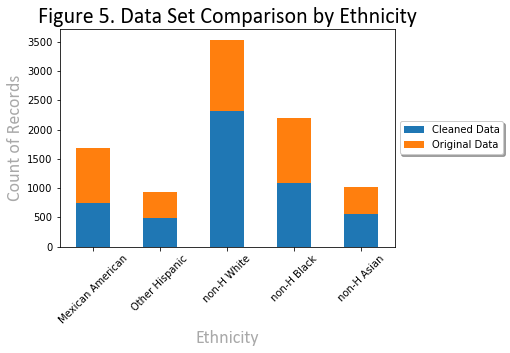

In [14]:
font1 = {'family':'calibri','color':'darkgray','size':18}
font2 = {'family':'calibri','color':'black','size':22}

plt.figure(figsize=(25,25))
ct = pd.crosstab(orig.RIDRETH3, orig.DataSet)
    
ax = ct.plot(kind='bar', stacked=True, rot= 45)
ax.legend(ncol=1, shadow=True, loc='center left', bbox_to_anchor=(1, 0.5)) 


plt.xlabel("Ethnicity", fontdict=font1)
plt.ylabel("Count of Records", fontdict = font1)
plt.title("Figure 5. Data Set Comparison by Ethnicity", fontdict = font2)
ax.set_xticklabels(['Mexican American', 'Other Hispanic', 'non-H White', 'non-H Black', 'non-H Asian'])


plt.show()

When reviewing the % of data removed due to missing values, the records for non-H White had a higher % of their original data represented (48%) vs other ethnicities only having 30-35% of their original data included.

### Drop feature columns with more than 20% missing data 

In [15]:
#drop columns with more than no missing data
df_merge= df_merge.dropna(thresh= 0.8*len(df_merge), axis=1)

### Drop non-numeric columns

In [16]:
# exclude non-numeric values
df_merge = df_merge.select_dtypes(['number'])
print(len(df_merge.columns), 'columns left')

291 columns left


In [17]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5372 entries, 0 to 9808
Columns: 291 entries, SEQN to phq9
dtypes: float64(278), int64(13)
memory usage: 12.0 MB


### Impute missing values 

In [18]:
imp_mode=SimpleImputer(strategy='most_frequent')
df_merge = pd.DataFrame(imp_mode.fit_transform(df_merge), columns=df_merge.columns)
#could try other imputation method KNN

## 3.3 Feature selection (initial selection)

To achieve our goal of building a model with questions that are brief and easy to ask, we went through a manual selection of features. This step includes dropping administration-related features (e.g., language of interview, interpreter code), features that require lengthy dietary assessments, and duplicated questions.

In [19]:
#go over the dictionary manually and drop the unwanted variables
col = df_merge.columns
df_col = cbook[cbook['variable'].isin(col)]
df_col.to_csv(r'df_col.csv') #done in excel

In [20]:
#remove variables that are related to administration/operation (e.g. language of interview, interpreter code)
#admin = pd.read_csv('C:/Users/AmroHassan/Google Drive/Classroom/31008 1-Data Mining Principles/Project/Depression-risk-main/Project Data/Depression-risk-main/data/administrative_col.csv')
admin = pd.read_csv('administrative_col.csv')
admin_col = admin.columns
df_merge = df_merge.drop(admin.columns, 1)

In [21]:
#remove variables that are collected and calculated after very detailed Dietary Interviews
#(e.g. total dietary fiber)
#Can keep variables that can be easily answered
#(e.g. Total bottled water drank yesterday)
#dietary = pd.read_csv('C:/Users/AmroHassan/Google Drive/Classroom/31008 1-Data Mining Principles/Project/Depression-risk-main/Project Data/Depression-risk-main/data/diet_col.csv')
dietary = pd.read_csv('diet_col.csv')
diet_col = dietary.columns
df_merge = df_merge.drop(dietary.columns, 1)

FileNotFoundError: [Errno 2] No such file or directory: 'diet_col.csv'

In [ ]:
# remove one of HUQ010 and HSD010 (identical question asked in different surveys, highly correlated)
df_merge = df_merge.drop('HUQ010', 1)

In [ ]:
df_merge.info()

In [ ]:
df_merge.to_csv(r'df_merge.csv')

In [ ]:
df_merge.shape

Now, after cleaning, only 211 columns left

## 3.4 Target variable (PHQ9) definition and visualization

The PHQ-9 was found to have acceptable diagnostic properties for detecting major depressive disorder for cut-off scores between 8 and 11. We explore this variable in two different ways: 

* PHQ9 itself is a numeric feature with a possible range from 0 to 27
* PHQ9 was dichotomized in (>=8/<8) to determine depression
* We also explored more restrict thresholds that have been used conventionally to define depression such as moderate and severe depression. 
* We further explored frequencies of suicidal ideation. 
* We end up using the ">=8/<8" threshold to define depression in the current project for the other definitions result in too few cases of depression to develop a prediction model. 

#### Numeric PHQ9 

In [ ]:
sns.histplot(df_merge.phq9, discrete=True)
plt.xlabel("Numeric PHQ9 Score", fontdict=font1)
plt.ylabel("Count of Records", fontdict = font1)
plt.title("Figure 2. Distribution of PHQ9 Score", fontdict = font2)

#### Depression (dichotomized)

In [ ]:
df_merge['mild_dep']= np.where(df_merge['phq9']>=8,1,0)
print('mild', df_merge['mild_dep'].value_counts())

In [ ]:
dx = sns.countplot(x='mild_dep', data = df_merge, palette = "GnBu")
dx.set_ylabel("Count of Records", fontdict = font1)
dx.set_xlabel("PHQ9 Category", fontdict=font1)
dx.set_title('Figure 3. Depression Count (phq9>=8)', y=1.03, fontdict=font2)
dx.set_xticklabels(['Non- Dep','Dep'])

plt.show()

#### Moderate depression

In [ ]:
df_merge['mod_dep']= np.where(df_merge['phq9']>=15,1,0)
print('modereate', df_merge['mod_dep'].value_counts())

In [ ]:
dx = sns.countplot(x='mod_dep', data = df_merge, palette = "GnBu")
dx.set_ylabel("Count of Records", fontdict = font1)
dx.set_xlabel("PHQ9 Category", fontdict=font1)
dx.set_title('Mod Depression Count', y=1.03, fontdict=font2)
dx.set_xticklabels(['Non-Mod Dep','Mod Dep'])

#### Severe depression

In [ ]:
df_merge['sev_dep']= np.where(df_merge['phq9']>=20,1,0)
print('severe', df_merge['sev_dep'].value_counts())

In [ ]:
dx = sns.countplot(x='sev_dep', data = df_merge, palette = "GnBu")
dx.set_ylabel("Count of Records", fontdict = font1)
dx.set_xlabel("PHQ9 Category", fontdict=font1)
dx.set_title('Severe Depression Count', y=1.03, fontdict=font2)
dx.set_xticklabels(['Non-Sev Dep','Sev Dep'])

plt.show()

#### Suicidal ideation

In [ ]:
df_merge['suicidal']= np.where(df_merge['DPQ090']>0,1,0)
print('suicidal', df_merge['suicidal'].value_counts())

In [ ]:
dx = sns.countplot(x='suicidal', data = df_merge, palette = "GnBu")
dx.set_ylabel("Count of Records", fontdict = font1)
dx.set_xlabel("PHQ9 Category", fontdict=font1)
dx.set_title('Suicidal Depression Count', y=1.03, fontdict=font2)
dx.set_xticklabels(['Non-Suicidal','Suicidal'])

plt.show()

## 3.4 Other key features exploration
We explored other key demographic features to describe this population. 

* A large proportion of the population is non-Hispanic white while there are also Hispanics, non-Hispanic blacks, and non-Hispanic Asians. 

* People's age ranges from 18 to 80 with larger proportions of the youngest and the oldest group. 

* There are more females than males. This population is also highly educated. About a quarter of the population was not US-born. 

### Race and ethnicity 

In [ ]:
dx = sns.countplot(x='RIDRETH3', data = df_merge, palette = "GnBu")
dx.set_ylabel("Count of Records", fontdict = font1)
dx.set_xlabel("Ethnicity", fontdict=font1)
dx.set_title('Records by Ethnicity', y=1.03, fontdict=font2)
dx.set_xticklabels(['Mexican American', 'Other Hispanic', 'non-H White', 'non-H Black', 'non-H Asian'])

plt.show()

### Explore Age, Education, Country of Birth, and Gender

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
font1 = {'family':'calibri','color':'gray','size':10}
font2 = {'family':'calibri','color':'black','size':15}

d1=sns.histplot(data=df_merge, x="RIDAGEYR", kde=True, color="skyblue", ax=axs[0, 0])
d2=sns.countplot(data=df_merge, x="RIAGENDR", palette="GnBu", ax=axs[0, 1])
d3=sns.countplot(data=df_merge, x="DMDBORN4", palette='GnBu', ax=axs[1, 0])
d4=sns.countplot(data=df_merge, x="DMDEDUC2", palette="GnBu", ax=axs[1, 1])

d1.set_ylabel("Count of Records", fontdict = font1)
d1.set_xlabel("Age in Years", fontdict=font1)
d1.set_title('Age', y=1.03, fontdict=font2)


d2.set_ylabel("Count of Records", fontdict = font1)
d2.set_xlabel("Gender", fontdict=font1)
d2.set_title('Gender', y=1.03, fontdict=font2)
d2.set_xticklabels(['Male (1)','Female (2)'])

d3.set_ylabel("Count of Records", fontdict = font1)
d3.set_xlabel("Country of Birth", fontdict=font1)
d3.set_title('Country of Birth', y=1.03, fontdict=font2)
d3.set_xticklabels(['United States (1)','Not in United States (2)'])

d4.set_ylabel("Count of Records", fontdict = font1)
d4.set_xlabel("Level", fontdict=font1)
d4.set_title('Education Attainment', y=1.03, fontdict=font2)
d4.set_xticklabels(['less than high school', 'some high school', 'high school graduate/GED or equivalent',  
                    'some college or AA degree)', 'college graduate or above'], rotation = 90)

plt.show()

## 3.5 Feature selection (feature importance)

### Create a function for normalizing data 

In [ ]:
from sklearn.preprocessing import StandardScaler 
def normalize_data(X): 
    X_std= pd.DataFrame(StandardScaler().fit_transform(X))
    X_std.columns= X.columns
    return X_std

In [ ]:
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
#partition into X and y
target=['mild_dep']
drop_features= ['phq9',
                'SEQN',
                'DPQ010', 'DPQ020', 'DPQ030', 'DPQ040', 'DPQ050', 'DPQ060','DPQ070','DPQ080', 'DPQ090',
               'mild_dep', 'sev_dep', 'suicidal', 'mod_dep']
X = df_merge[df_merge.columns.drop(drop_features)]
y= df_merge[target]
#normalize predictors
X= normalize_data(X)
# training and validation sets split
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
print('Training_X: ', train_X.shape)
print('Validation_X: ', valid_X.shape)
print('Training_y: ', train_y.shape)
print('Validation_y: ', valid_y.shape)


### XGboost for feature selection

We used XGBoost to estimate the importance of features and selected the top 30 features with highest importance. Importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. Importance is calculated from each single decision tree by the among that each attribute split improves the performance measure, weighted by the number of observations the node is responsible for. Feature importances were then averaged across all trees in the model. 

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
xgboost = XGBClassifier()
xgboost.fit(train_X, train_y)
importance= xgboost.feature_importances_
columns= df_merge.columns
df = pd.DataFrame({'feature': train_X.columns, 'importance': importance})
df = df.sort_values('importance', ascending=False)

In [ ]:
#select top 30 features 
df30= df[:30]
df30.columns=['variable', 'importance']
df30['variable'] = df30['variable'].apply(lambda x: x.upper())
df30 = pd.merge(left=df30, right=cbook, left_on='variable', right_on='variable', how='left')

In [ ]:
df30

In [ ]:
#confusion matrix
classificationSummary(valid_y, xgboost.predict(valid_X))

#### above shows the problem of imbalanced data

## 3.6 Apply SMOTE to the training set
A problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary. One way to solve this problem is to oversample the examples in the minority class. SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line. Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space. (https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

In [ ]:
import imblearn
from collections import Counter
from sklearn.datasets import make_classification
print(imblearn.__version__)

In [ ]:
#recreate X,y for mild depression
target=['mild_dep']
drop_features= ['phq9',
                'SEQN',
                'DPQ010', 'DPQ020', 'DPQ030', 'DPQ040', 'DPQ050', 'DPQ060','DPQ070','DPQ080', 'DPQ090',
               'mild_dep', 'sev_dep', 'suicidal', 'mod_dep']
X = df_merge[df_merge.columns.drop(drop_features)]
y= df_merge[target]
#normalize predictors
X= normalize_data(X)
# training and validation sets split
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
print('Training_X: ', train_X.shape)
print('Validation_X: ', valid_X.shape)
print('Training_y: ', train_y.shape)
print('Validation_y: ', valid_y.shape)

In [ ]:
train_y.value_counts()

In [ ]:
valid_y.value_counts()

### The combination of SMOTE and under-sampling (trim the majority class) performs bettern than plain under-sampling (https://arxiv.org/abs/1106.1813)

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [ ]:
#oversample the minority class to have 40% the number of examples of the majority class
over = SMOTE(sampling_strategy=0.4)
#reduce the number of examples in the majority class to have 50% more than the minority class
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [ ]:
train_X, train_y=pipeline.fit_resample(train_X, train_y)

In [ ]:
train_y.value_counts()

In [ ]:
#test set remain the same
valid_y.value_counts()

### Re-run feature selection using the more balanced data 

In [ ]:
xgboost.fit(train_X, train_y)
importance= xgboost.feature_importances_
columns= df_merge.columns
df = pd.DataFrame({'feature': train_X.columns, 'importance': importance})
df = df.sort_values('importance', ascending=False)
#select top 20 features 
df20= df[:20]
df20.columns=['variable', 'importance']
df20['variable'] = df20['variable'].apply(lambda x: x.upper())
df20 = pd.merge(left=df20, right=cbook, left_on='variable', right_on='variable', how='left')

In [ ]:
df20

In [ ]:
df20.to_csv(r'df20.csv')

### The classification results are improved (more true positive) after balancing data
However, this does not fully solve the problem of having way too fewer minority than majority class in the target variable. One could applied resampling strategies as we did to both training and testing sets to get a better results in this regards. But we decided to remain the testing set "real" to reduced bias from resampling. 

In [ ]:
classificationSummary(valid_y, xgboost.predict(valid_X))

## 3.7 Selected variables and correlation matrix 

In [ ]:
var_list= df20.variable.tolist()
var_list.append('mild_dep')
print(var_list)

In [ ]:
#final dfs of balanced training data 
train_y= train_y.filter(var_list)
train_X= train_X.filter(var_list)
#final testing set 
valid_y= valid_y.filter(var_list)
valid_X= valid_X.filter(var_list)

In [ ]:
train_y.value_counts()

In [ ]:
valid_y.value_counts()

In [ ]:
ax=plt.subplots(figsize=(6,6))
corr=train_X.corr()
sns.heatmap(corr, cmap=sns.cm.rocket_r)

In [ ]:
#get highly correlated pairs, ranked by absolute correlation values 
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [ ]:
get_top_abs_correlations(train_X, 10)

Narrowed down to 20 predictors; some of them are correlated but since we are interested in prediction instead of inference, this level of multicolineraity between variables is acceptable.

In [ ]:
train_X.shape

# 4. Shortlist promising models 

The training set is used to fit a few candidate models with repeated 10-folds cross-validation. We evaluated these models using average accuracy scores and average Receiver Operation Characteristics (ROC) Area Under Curve (AUC) scores from the cross-validation. The AUC score is a more unbiased estimate with imbalanced classification like ours (Brownlee, 2021). After an optimal model is selected based on the best cross-validation results, we re-trained the selected model using the full training set. This trained model would be our final model and its performance would be evaluated for its AUC score using the held-out test set. 

We used multiple supervised learning models for classification of moderate depression. We started with a **logistic regression** model and a **decision tree classification** as our baseline models. We then used ensemble methods that synthesize the results of multiple learning algorithms to achieve better predictive performance over a single estimator. These ensemble models include **random forests, adaptive boosting, and gradient boosting**. Grid search was used in tuning hyper-parameters of these models for the best performance.

## 4.1 Baseline model: logistic regression 

In [ ]:
from sklearn.linear_model import LogisticRegression
logit=LogisticRegression()
logit.fit(train_X, train_y)

In [ ]:
classificationSummary(train_y, logit.predict(train_X))

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from numpy import mean
from numpy import std
#cross-validation 
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# evaluate model
scores = cross_val_score(logit, train_X,train_y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

In [ ]:
coef= logit.coef_
coef= coef.flatten()
columns= train_X.columns
df = pd.DataFrame({'feature': columns, 
                   'coefficients': coef})
df = df.sort_values('coefficients', ascending=False)
df.columns=['variable', 'coefficients']
df['variable'] = df['variable'].apply(lambda x: x.upper())
df = pd.merge(left=df, right=cbook, left_on='variable', right_on='variable', how='left')

In [ ]:
df

In [ ]:
import statsmodels.api as sm
logitsm= sm.Logit(train_y, train_X).fit()
logitsm.summary()

### ROC curve

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import RocCurveDisplay
from scipy import interp

In [ ]:
fig2 = plt.figure(figsize=[6,6])
clf= logit
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(train_X,train_y):
    prediction = clf.fit(train_X.iloc[train],train_y.iloc[train]).predict_proba(train_X.iloc[test])
    fpr, tpr, t = roc_curve(train_y.iloc[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.3f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.3f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of logistic regression with 10-fold cross validation')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()

## 4.2 Baseline model: Decision tree classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV 

param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': list(range(2,10)), 
    'min_samples_split': list(range(2,6))
}

gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, 
                          n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('initial score: ', gridSearch.best_score_)
print('parameters: ', gridSearch.best_params_)

dtree = gridSearch.best_estimator_

In [ ]:
#cross-validation using training set
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# evaluate model
scores = cross_val_score(dtree, train_X,train_y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

In [ ]:
fig2 = plt.figure(figsize=[6,6])
clf= dtree
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(train_X,train_y):
    prediction = clf.fit(train_X.iloc[train],train_y.iloc[train]).predict_proba(train_X.iloc[test])
    fpr, tpr, t = roc_curve(train_y.iloc[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.3f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.3f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of decision tree classifier with 10-fold cross validation')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()

## 4.3 Tree-based ensemble classification models: Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV 

param_grid = {
    'max_leaf_nodes': list(range(2, 100)),
    'min_samples_split': [3,4,5,7]
}
gridSearch = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, 
                          n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('initial score: ', gridSearch.best_score_)
print('parameters: ', gridSearch.best_params_)

rf = gridSearch.best_estimator_

In [ ]:
#cross-validation using training set
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# evaluate model
scores = cross_val_score(rf, train_X,train_y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

### ROC curve

In [ ]:
fig2 = plt.figure(figsize=[6,6])
clf= rf
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(train_X,train_y):
    prediction = clf.fit(train_X.iloc[train],train_y.iloc[train]).predict_proba(train_X.iloc[test])
    fpr, tpr, t = roc_curve(train_y.iloc[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.3f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.3f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('random forest classification')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()

## 4.4 Tree-based ensemble classification models: AdaBoost 

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

param_grid = {
    'n_estimators': [40, 50, 60],
    'learning_rate': [1, 1.2, 1.5, 1.9]
}
gridSearch = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid, cv=5, 
                          n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('initial score: ', gridSearch.best_score_)
print('parameters: ', gridSearch.best_params_)

ada = gridSearch.best_estimator_

In [ ]:
#cross-validation using training set
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# evaluate model
scores = cross_val_score(ada, train_X,train_y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

### ROC curve 

In [ ]:
fig3 = plt.figure(figsize=[6,6])
clf= ada
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(train_X,train_y):
    prediction = clf.fit(train_X.iloc[train],train_y.iloc[train]).predict_proba(train_X.iloc[test])
    fpr, tpr, t = roc_curve(train_y.iloc[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.3f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.3f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('adaptive boosting')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()

## 4.5 Tree-based ensemble classification models: Gradient Boosting 

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'n_estimators': [60, 70, 80],
    'max_depth': [ 7,8,9], 
    'min_impurity_decrease': [0.1, 0.2, 0.3]
}
gridSearch = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=5, 
                          n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('initial score: ', gridSearch.best_score_)
print('parameters: ', gridSearch.best_params_)

gradient = gridSearch.best_estimator_

In [ ]:
#cross-validation using training set
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# evaluate model
scores = cross_val_score(gradient, train_X,train_y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

In [ ]:
fig4 = plt.figure(figsize=[6,6])
clf= gradient
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(train_X,train_y):
    prediction = clf.fit(train_X.iloc[train],train_y.iloc[train]).predict_proba(train_X.iloc[test])
    fpr, tpr, t = roc_curve(train_y.iloc[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.3f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.3f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('gradient boosting')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()

## 4.6 Tree-based ensemble classification models: XGBoost 

In [ ]:
param_grid = {
    'n_estimators': [60, 70, 80],
    'max_depth': [ 7,8,9], 
    'min_impurity_decrease': [0.1, 0.2, 0.3]
}
gridSearch = GridSearchCV(XGBClassifier(random_state=42), param_grid, cv=5, 
                          n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('initial score: ', gridSearch.best_score_)
print('parameters: ', gridSearch.best_params_)

xgboost = gridSearch.best_estimator_

In [ ]:
#cross-validation using training set
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# evaluate model
scores = cross_val_score(xgboost, train_X,train_y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

In [ ]:
fig5 = plt.figure(figsize=[6,6])
clf= xgboost
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(train_X,train_y):
    prediction = clf.fit(train_X.iloc[train],train_y.iloc[train]).predict_proba(train_X.iloc[test])
    fpr, tpr, t = roc_curve(train_y.iloc[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.3f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.3f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('xgboost')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()

# 5. Evaluate the best model in the testing set

## 5.1 Test it in the held-out test set 

In [ ]:
valid_y.value_counts()

In [ ]:
valid_X.shape

We decide to use the Random Forest model as the final model because it has the highest AUC, which is our major consideration of model performance. It also has a pretty high accuracy score, very close to the highest ones achieved by AdaBoost and Gradient Boosting.

In [ ]:
#retrain the selected model with full training set 
rf= sklearn.base.clone(rf)
rf.fit(train_X, train_y)
#test in the hold-out test set
classificationSummary(valid_y, rf.predict(valid_X))

In [ ]:
from sklearn import metrics
y_pred_proba = rf.predict_proba(valid_X)[::,1]

#calculate AUC of model
auc = metrics.roc_auc_score(valid_y, y_pred_proba)

#print AUC score
print(auc)

In [ ]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(rf, valid_X, valid_y)

For model performance, we are more interested in AUC than accuracy scores because of our imbalanced data as well as our research aim, where we care about the sensitivity and specificity of our model. Our final best model has an AUC of 0.82. In general, 0.7 to 0.8 is considered acceptable, 0.8 to 0.9 is considered excellent, and more than 0.9 is considered outstanding.

## 5.2 Final visualization

In [ ]:
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [ ]:
#add codebook names 
importance= rf.feature_importances_
columns= train_X.columns
df = pd.DataFrame({'feature': columns, 
                   'importance': importance})
df = df.sort_values('importance', ascending=False)
df.columns=['variable', 'importance']
df['variable'] = df['variable'].apply(lambda x: x.upper())
df = pd.merge(left=df, right=cbook, left_on='variable', right_on='variable', how='left')

In [ ]:
plot_feature_importance(rf.feature_importances_,df.label,'RANDOM FOREST ')